# Example 5.3 — LED Accelerated Degradation Analysis with Dual Stresses

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-09-29  
**Version:** 1.1  

---
## Problem Statement

In this accelerated degradation test (ADT), the light output of LED lamps is monitored over time. The study follows the approach reported by (Pan and Crispin, 2011), focusing on how performance declines under different stress conditions. The stress factors are **ambient temperature** and **forward current**; these are controlled during testing, while the LED’s light output is periodically measured.

An LED is considered to have **failed** when its light output falls below **70%** of its initial luminous intensity, i.e., when the normalized performance level satisfies $D(t) < 0.70$.

**Normal use condition:** $T = 30^{\circ}\mathrm{C}$, $I = 400~\mathrm{mA}$.

**Test Conditions (Table 5.5)**

| Condition | $T$ (°C) | $I$ (mA) | No. of LEDs |
|:--------:|:--------:|:--------:|:-----------:|
| 1 | 77 | 700 | 8 |
| 2 | 77 | 500 | 14 |
| 3 | 45 | 700 | 14 |

## Degradation Model

Consider the following nonlinear model for the performance decline of LED luminosity:

$$
D_i\!\left(t_{ij}\right) \;=\; \left( 1 + \gamma_0 \, t_{ij}^{\gamma_1} \right)^{-1},
\qquad i=1,\dots,36,\quad j=1,\dots,4
$$

- $i$ indexes test units, $j$ indexes measurement instants.  
- $D_i$ is the normalized performance level (luminosity), with $D_i(0)=1$.  
- $\gamma_0$ is the degradation-rate term that depends on testing temperature and forward current.  
- $\gamma_1$ is the time-shape parameter.  

---

## Objective

Using the least squares (LSQ) method of ADT, **estimate the model parameters** $\gamma_0$ and $\gamma_1$ from the performance degradation data **summarized in Table 5.6**, and **estimate the use life** at the normal use condition $(T=30^{\circ}\mathrm{C}, I=400~\mathrm{mA})$ based on the failure criterion $D(t)<0.70$.

## Method

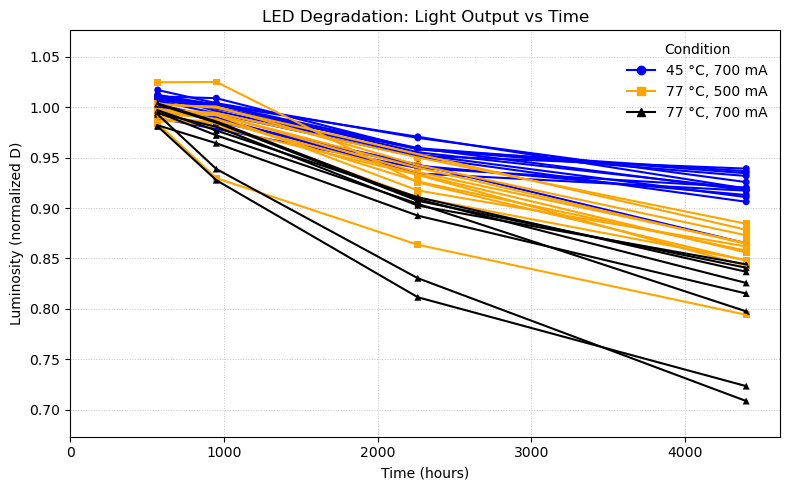

In [1]:
# 0) Load data and basic preprocessing
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import arviz as az
import scipy.stats as st

from scipy.optimize import least_squares, brentq, minimize
from scipy.stats import norm, linregress,weibull_min, gamma, lognorm
from reliability.Fitters import Fit_Everything, Fit_Weibull_2P, Fit_Gamma_2P, Fit_Lognormal_2P

# --- Load data (wide) ---
df = pd.read_csv("Example_5.3_LED_degradation_data.csv")
# Expected columns: Unit, T (°C), I (mA), 569 (hr), 950 (hr), 2261 (hr), 4397 (hr)
df = df[~df["Unit"].isin([15, 22])].reset_index(drop=True)

# --- Tidy to long format: (Unit, T_C, I_mA, time_hr, D) ---
time_cols = [c for c in df.columns if "(hr)" in c]
df_long = df.melt(
    id_vars=["Unit", "T (°C)", "I (mA)"],
    value_vars=time_cols,
    var_name="time_hr",
    value_name="D"
).dropna()

df_long["time_hr"] = df_long["time_hr"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)
df_long = df_long.rename(columns={"T (°C)": "T_C", "I (mA)": "I_mA"})

# Add Kelvin column for modeling
df_long["T_K"] = df_long["T_C"] + 273.15

df_long = df_long.sort_values(["Unit", "time_hr"]).reset_index(drop=True)

# Save your DataFrame as a CSV
df_long.to_csv("Example_5.3_LED_degradation_data_long.csv", index=False)

# --- Map each observation to a stress "cell": unique (T_C, I_mA) ---
cells = sorted(df_long[["T_C", "I_mA"]].drop_duplicates().itertuples(index=False, name=None))
cell_to_idx = {cell: k for k, cell in enumerate(cells)}
df_long["cell_idx"] = [cell_to_idx[(r.T_C, r.I_mA)] for r in df_long.itertuples(index=False)]

t_time = df_long["time_hr"].to_numpy()
D_obs = df_long["D"].to_numpy()
T_acc_K = df_long["T_K"].to_numpy()
T_degC = df_long["T_C"].to_numpy()
I = df_long["I_mA"].to_numpy()

# --- Plot styling for LED degradation ---
# Define colors + markers per (Temperature, Current) condition
cond_styles = {
    (45, 700): {"color": "blue", "marker": "o"},
    (77, 500): {"color": "orange", "marker": "s"},
    (77, 700): {"color": "black", "marker": "^"}, 
}
TEMP_COLORS = {(45, 700): 'blue', (77, 500): 'orange', (77, 700): 'black'}
TEMP_MARKERS = {(45, 700): 'o', (77, 500): 's', (77, 700): '^'}

fig, ax = plt.subplots(figsize=(8, 5))

# Group by condition, then by unit
for (temp, current), gcond in df_long.groupby(["T_C", "I_mA"]):
    color = TEMP_COLORS.get((temp, current), 'tab:gray')
    marker = TEMP_MARKERS.get((temp, current), 'o')

    for i, (unit, gunit) in enumerate(gcond.groupby("Unit")):
        gunit = gunit.sort_values("time_hr")
        ax.plot(gunit["time_hr"].values, gunit["D"].values, label=None, linewidth=1.5, color=color)
        ax.scatter(gunit["time_hr"].values, gunit["D"].values, s=25, marker=marker, color=color, edgecolors="none")

# Legend: one entry per condition
handles, labels = [], []
for (temp, current), style in cond_styles.items():
    h = ax.plot([], [], color=style["color"], marker=style["marker"], linestyle="-", linewidth=1.5)[0]
    handles.append(h)
    labels.append(f"{temp} °C, {current} mA")

ax.legend(handles, labels, title="Condition", frameon=False, ncol=1, loc="best")

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Luminosity (normalized D)")
ax.set_title("LED Degradation: Light Output vs Time")

ax.set_xlim(0, df_long["time_hr"].max()*1.05)
ax.set_ylim(df_long["D"].min()*0.95, df_long["D"].max()*1.05)
ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.savefig("Example5.3.png", dpi=300)
plt.show()


LSQ params: gamma0=2.25927e-09, gamma1=1.29963, Ea=0.239183, n=0.706383
RMS residual: 0.0235012


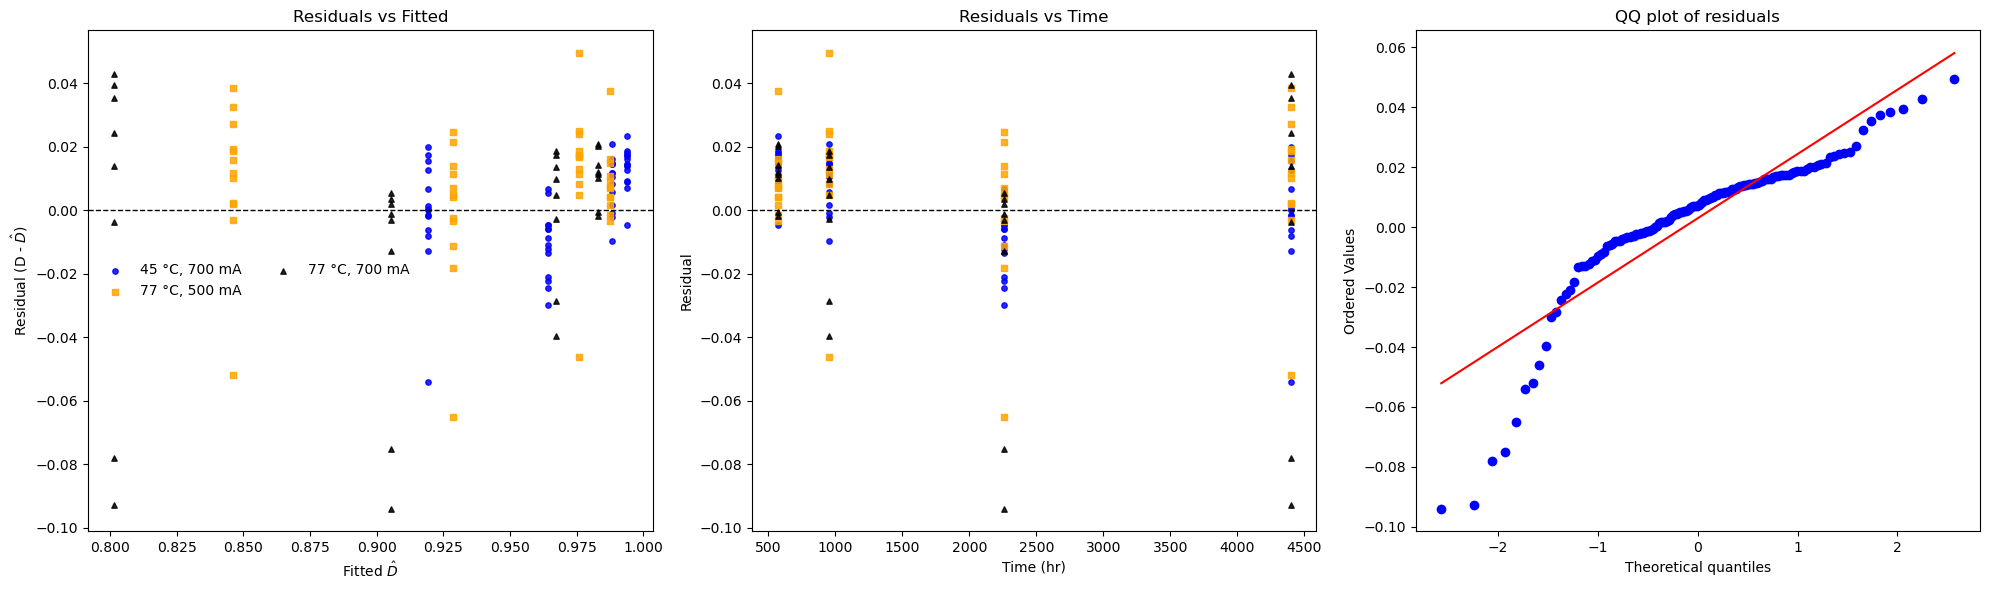

In [3]:
# 1) LSQ estimation of physics-informed degradation model
# -----------------------------

T_use = 303.15              # 30 °C in Kelvin
I_use = 400                 # mA
K_eV_perK = 8.617e-5        # Boltzmann const (eV/K)

# Use Kelvin in the exp term
# T_acc_K should be Temperature_C + 273.15 as float

def mu_D(params, t, T_accK, I, T_use=T_use):
    gamma0, gamma1, Ea, n = params
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_accK))
    return (1.0 + gamma0 * (accel * I**n * t) ** gamma1) ** (-1.0)

def resid(params, t, T_accK, I, D):
    return D - mu_D(params, t, T_accK, I)

# Bounds consistent with thermal physics and your data scale
p0 = [9e-4, 0.63, 0.30, 0.5]                   # start: gamma0, gamma1, Ea[eV], n
bounds = ([1e-20, 1e-2, 1e-3, 1e-3], [1e2, 10.0, 2.0, 10])
lsq = least_squares(resid, p0, args=(t_time, T_acc_K, I, D_obs), bounds=bounds)

lsq = least_squares(resid, p0, args=(t_time, T_acc_K, I, D_obs), bounds=bounds)
gamma0_hat, gamma1_hat, Ea_hat, n_hat = lsq.x
residuals = lsq.fun
rms = float(np.sqrt(np.mean(residuals**2)))
print(f"LSQ params: gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}, n={n_hat:.6g}")
print(f"RMS residual: {rms:.6g}")

D_hat = mu_D(lsq.x, t_time, T_acc_K, I)

# -----------------------------
# 2.5) LSQ Residual diagnostics visualization (by condition)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Helper to fetch style by (temp, current)
def _style_for(temp_c, current_mA):
    color = TEMP_COLORS.get((temp_c, current_mA), "tab:gray")
    marker = TEMP_MARKERS.get((temp_c, current_mA), "o")
    return color, marker

# Unique conditions present in the long data
conds = sorted(set(zip(T_degC.astype(int), I.astype(int))))

# a) Residuals vs Fitted, colored by (T, I)
for (temp_c, current_mA) in conds:
    m = (T_degC.astype(int) == temp_c) & (I.astype(int) == current_mA)
    color, marker = _style_for(temp_c, current_mA)
    axes[0].scatter(D_hat[m], residuals[m], s=15, color=color, marker=marker, alpha=0.85,
                    label=f"{temp_c} °C, {current_mA} mA")
axes[0].axhline(0, color="k", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted $\\hat{D}$")
axes[0].set_ylabel("Residual (D - $\\hat{D}$)")
axes[0].set_title("Residuals vs Fitted")
axes[0].legend(frameon=False, ncol=2)

# b) Residuals vs Time, colored by (T, I)
for (temp_c, current_mA) in conds:
    m = (T_degC.astype(int) == temp_c) & (I.astype(int) == current_mA)
    color, marker = _style_for(temp_c, current_mA)
    axes[1].scatter(t_time[m], residuals[m], s=15, color=color, marker=marker, alpha=0.85)
axes[1].axhline(0, color="k", linestyle="--", linewidth=1)
axes[1].set_xlabel("Time (hr)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals vs Time")

# c) QQ plot of residuals (overall)
st.probplot(residuals, dist=st.norm, plot=axes[2])
axes[2].set_title("QQ plot of residuals")

plt.tight_layout()
plt.show()


In [4]:
# 2) MLE parameter estimation (Gaussian stochastic errors)
# -----------------------------
# We maximize the Gaussian log-likelihood over (gamma0, gamma1, Ea, sigma).
# To enforce positivity, we optimize in log-space.

# Negative log-likelihood for Gaussian errors
def nll_logparams(theta_log, t, T_acc_K, I, D_obs, T_use=T_use):
    log_g0, log_g1, log_Ea, log_n, log_sig = theta_log
    g0, g1, Ea, n, sig = np.exp(log_g0), np.exp(log_g1), np.exp(log_Ea), np.exp(log_n), np.exp(log_sig)
    if not np.isfinite(g0*g1*Ea*n*sig) or sig <= 0:
        return np.inf
    mu = mu_D([g0, g1, Ea,n], t, T_acc_K, I, T_use=T_use)
    res = D_obs - mu
    return 0.5 * np.sum((res/sig)**2 + 2.0*np.log(sig) + np.log(2*np.pi))

# Initialize near LSQ solution
init_log = np.log([max(gamma0_hat, 1e-12), max(gamma1_hat, 1e-3), max(Ea_hat, 1e-6), max(n_hat, 1e-6), # params
                   max(np.std(residuals, ddof=3), 1e-6)])  # sigma start

mle_res = minimize(nll_logparams, init_log, args=(t_time, T_acc_K, I, D_obs), method='L-BFGS-B')

if not mle_res.success:
    print("WARNING: MLE optimizer did not converge:", mle_res.message)

# Transform back to real space
log_g0_mle, log_g1_mle, log_Ea_mle, log_n_mle, log_sig_mle = mle_res.x

g0_mle, g1_mle, Ea_mle, n_mle, sig_mle = np.exp([log_g0_mle, log_g1_mle, log_Ea_mle, log_n_mle, log_sig_mle])

print(f"MLE parameters:      gamma0={g0_mle:.6g}, gamma1={g1_mle:.6g}, Ea={Ea_mle:.6g}, n={n_mle:.6g}, sigma={sig_mle:.6g}")
print(f"Comparisons: LSQ  -> gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}, n={n_hat:.6g}")

# Optional: compute MLE fitted values & RMS (for quick comparison)
yhat_mle = mu_D([g0_mle, g1_mle, Ea_mle, n_mle], t_time, T_acc_K, I)
res_mle  = D_obs - yhat_mle
rms_mle  = np.sqrt(np.mean(res_mle**2))
print(f"RMS residual (MLE): {rms_mle:.6g}")

MLE parameters:      gamma0=1.36676e-10, gamma1=1.31323, Ea=0.242439, n=1.01475, sigma=0.0230694
Comparisons: LSQ  -> gamma0=2.25927e-09, gamma1=1.29963, Ea=0.239183, n=0.706383
RMS residual (MLE): 0.0230694


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:57<00:00, 112.41it/s]


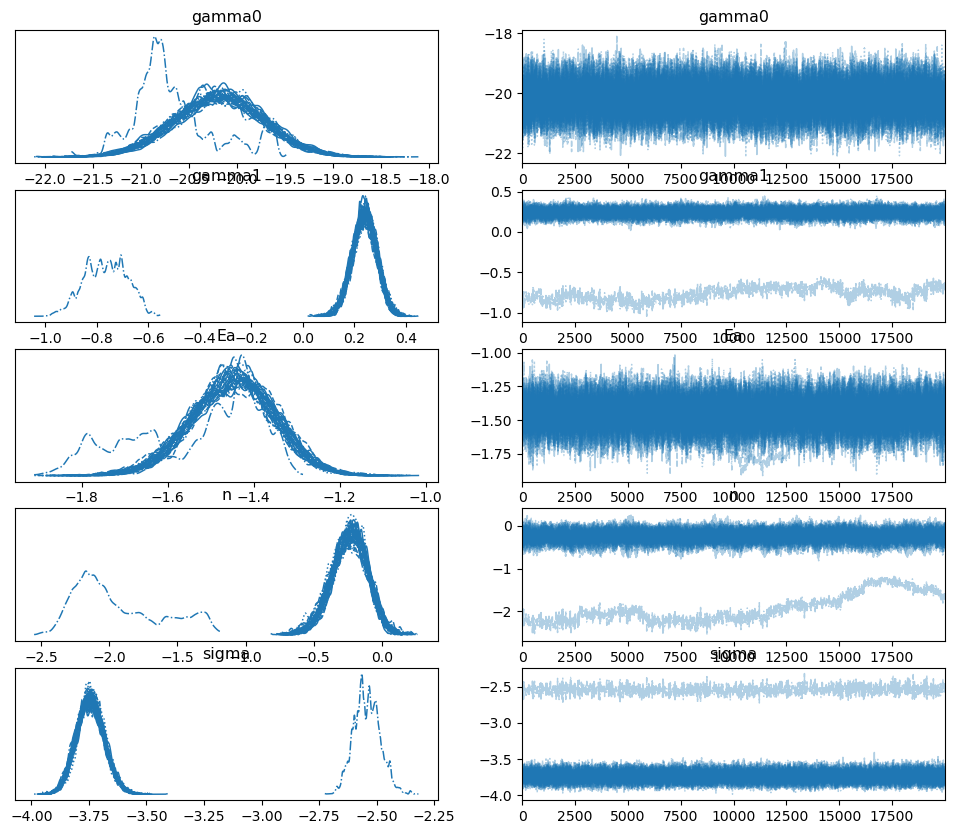

Bayes parameters:    gamma0=1.89641e-09, gamma1=1.24644, Ea=0.23556, n=0.774199, sigma=0.025453
MLE parameters:      gamma0=1.36676e-10, gamma1=1.31323, Ea=0.242439, n=1.01475, sigma=0.0230694
Comparisons: LSQ  -> gamma0=2.25927e-09, gamma1=1.29963, Ea=0.239183, n=0.706383


In [5]:
# 3) Baysian parameter estimation (Gaussian stochastic errors)
# -----------------------------

mu_logg0, sd_logg0 = np.log(gamma0_hat), 0.5
mu_logg1, sd_logg1 = np.log(gamma1_hat), 0.5
mu_logEa, sd_logEa = np.log(Ea_hat), 0.5
mu_logn, sd_logn   = np.log(n_hat), 0.5
mu_logs, sd_logs   = np.log(sig_mle), 0.5

def log_prior(theta):
    log_g0, log_g1, log_Ea, log_n, log_sig = theta
    # Normals
    lp  = -0.5*((log_g0 - mu_logg0)/sd_logg0)**2 - np.log(sd_logg0*np.sqrt(2*np.pi))
    lp += -0.5*((log_g1 - mu_logg1)/sd_logg1)**2 - np.log(sd_logg1*np.sqrt(2*np.pi))
    lp += -0.5*((log_sig - mu_logs)/sd_logs)**2 - np.log(sd_logs*np.sqrt(2*np.pi))
    lp += -0.5*((log_Ea - mu_logEa)/sd_logEa)**2 - np.log(sd_logEa*np.sqrt(2*np.pi))
    lp += -0.5*((log_n - mu_logn)/sd_logn)**2 - np.log(sd_logn*np.sqrt(2*np.pi))
    return lp

def log_likelihood(theta, t_time, T_acc_K, I, D_obs):
    log_g0, log_g1, log_Ea, log_n,log_sig = theta
    g0, g1, sig, Ea, n = np.exp(log_g0), np.exp(log_g1), np.exp(log_sig), np.exp(log_Ea), np.exp(log_n)
    # guard rails
    if not (np.isfinite(g0) and np.isfinite(g1) and np.isfinite(sig) and np.isfinite(Ea) and np.isfinite(n)) or sig <= 0 or Ea <= 0:
        return -np.inf
    mu = mu_D([g0, g1, Ea, n], t_time, T_acc_K, I)
    # Gaussian errors on D
    res = D_obs - mu
    ll = -0.5*np.sum((res/sig)**2 + 2.0*np.log(sig) + np.log(2*np.pi))
    return ll

def log_prob(theta, t_time, T_acc_K, I, D_obs):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, t_time, T_acc_K, I, D_obs)
    return lp + ll

# Initialize walkers near MLE solution / reasonable scales
init_logg0  = np.log(max(g0_mle, 1e-15))
init_logg1  = np.log(max(g1_mle, 1e-3))
init_logEa  = np.log(max(Ea_mle, 1e-3))
init_logn   = np.log(max(n_mle,  1e-3))
init_logsig = np.log(max(sig_mle, 1e-3))

ndim, nwalkers = 5, 32
rng = np.random.default_rng(123)
p0 = np.array([init_logg0, init_logg1, init_logEa, init_logn, init_logsig]) + \
     rng.normal(scale=[0.2, 0.1, 0.2, 0.2, 0.2], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(t_time, T_acc_K, I, D_obs))

# Burn-in + sampling
state = sampler.run_mcmc(p0, 10000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 20000, progress=True)

# Posterior draws (flattened)
chain = sampler.get_chain(flat=True)
log_g0_s, log_g1_s, log_Ea_s, log_n_s, log_sig_s = [chain[:,i] for i in range(ndim)]
g0_s, g1_s, sig_s, Ea_s, n_s = np.exp(log_g0_s), np.exp(log_g1_s), np.exp(log_sig_s), np.exp(log_Ea_s), np.exp(log_n_s)

labels = ["gamma0", "gamma1", "Ea", "n", "sigma"]

# after sampling with emcee or similar:
idata = az.from_emcee(sampler, var_names=labels)

# Get summary with HDI = 95%
az.plot_trace(idata)
plt.show()
#az.plot_pair(idata)

g0_s_mean, g1_s_mean, sig_s_mean, Ea_s_mean, n_s_mean = np.mean(g0_s), np.mean(g1_s), np.mean(sig_s), np.mean(Ea_s), np.mean(n_s)
print(f"Bayes parameters:    gamma0={g0_s_mean:.6g}, gamma1={g1_s_mean:.6g}, Ea={Ea_s_mean:.6g}, n={n_s_mean:.6g}, sigma={sig_s_mean:.6g}")
print(f"MLE parameters:      gamma0={g0_mle:.6g}, gamma1={g1_mle:.6g}, Ea={Ea_mle:.6g}, n={n_mle:.6g}, sigma={sig_mle:.6g}")
print(f"Comparisons: LSQ  -> gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}, n={n_hat:.6g}")

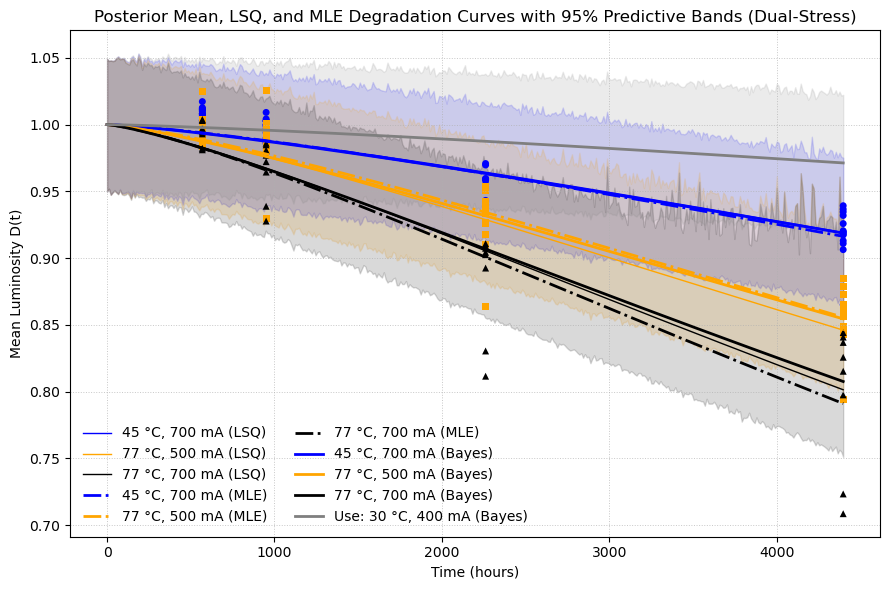

In [6]:
# 4) Parameter estimate validation visualization (dual-stress: Temperature & Current)
# -----------------------------

# Time grid for smooth curves
t_grid = np.linspace(0.0, float(np.max(t_time)), 400)

# Choose conditions to plot (use the styles dict keys so colors/markers match earlier)
conds_to_plot = list(cond_styles.keys())  # e.g., [(45,700), (77,500), (77,700)]

# Also show a "use" condition (pick a representative current; adjust as needed)
use_C = float(T_use - 273.15)
I_use = 400  # <-- change if your nominal current differs
conds_with_use = conds_to_plot + [(use_C, I_use)]

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0 = g0_s[sel]; _g1 = g1_s[sel]; _Ea = Ea_s[sel]; _sig = sig_s[sel]; _n = n_s[sel]

fig, ax = plt.subplots(figsize=(9, 6))

# --- LSQ point-estimate degradation curves (solid, thin) ---
for (Tc_lsq, I_lsq) in conds_to_plot:
    color_lsq  = TEMP_COLORS.get((Tc_lsq, I_lsq), 'tab:gray')
    T_eval_lsq = Tc_lsq + 273.15
    mu_lsq = mu_D([gamma0_hat, gamma1_hat, Ea_hat, n_hat], t_grid, T_eval_lsq, I_lsq)
    ax.plot(t_grid, mu_lsq, linestyle='-', linewidth=1, color=color_lsq,
            label=f"{int(Tc_lsq)} °C, {int(I_lsq)} mA (LSQ)")

# --- MLE point-estimate degradation curves (dash-dot, thicker) ---
for (Tc_mle, I_mle) in conds_to_plot:
    color_mle  = TEMP_COLORS.get((Tc_mle, I_mle), 'tab:gray')
    T_eval_mle = Tc_mle + 273.15
    mu_mle = mu_D([g0_mle, g1_mle, Ea_mle, n_mle], t_grid, T_eval_mle, I_mle)
    ax.plot(t_grid, mu_mle, linestyle='-.', linewidth=2, color=color_mle,
            label=f"{int(Tc_mle)} °C, {int(I_mle)} mA (MLE)")

# --- Posterior mean and 95% credible/predictive bands (by condition, incl. use) ---
for (Tc, I_eval) in conds_with_use:
    T_eval = Tc + 273.15

    # Acceleration term and current factor per posterior draw
    accel = np.exp(_Ea[:, None] / K_eV_perK * (1.0 / T_use - 1.0 / T_eval))       # (ns, 1)
    i_fac = (float(I_eval) ** _n)[:, None]                                         # (ns, 1)

    # Dual-stress physics-of-failure mean curve per draw:
    # mu = (1 + g0 * (t * accel * I^n)^g1)^(-1)
    base = t_grid[None, :] * accel * i_fac                                         # (ns, T)
    mu_draws = (1.0 + _g0[:, None] * (base ** _g1[:, None])) ** (-1.0)             # (ns, T)

    mu_mean = mu_draws.mean(axis=0)
    color = TEMP_COLORS.get((Tc, I_eval), 'tab:gray')
    label = (f"Use: {int(use_C)} °C, {int(I_use)} mA (Bayes)"
             if (Tc == use_C and I_eval == I_use)
             else f"{int(Tc)} °C, {int(I_eval)} mA (Bayes)")
    ax.plot(t_grid, mu_mean, color=color, linewidth=2, label=label)

    # 95% CrI on the mean curve (parameter uncertainty only)
    lo_mean, hi_mean = np.quantile(mu_draws, [0.025, 0.975], axis=0)

    # Posterior predictive (add observation noise)
    rng_ppc = np.random.default_rng(123)
    eps = rng_ppc.normal(size=mu_draws.shape)
    y_draws = mu_draws + _sig[:, None] * eps
    lo_pred, hi_pred = np.quantile(y_draws, [0.025, 0.975], axis=0)

    ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)

# --- Overlay scatter data points (by condition) ---
for (temp_c, current_mA), gcond in df_long.sort_values(['T_C', 'Unit', 'time_hr']).groupby(['T_C', 'I_mA']):
    color  = TEMP_COLORS.get((temp_c, current_mA), 'tab:gray')
    marker = TEMP_MARKERS.get((temp_c, current_mA), 'o')
    ax.scatter(gcond['time_hr'].values, gcond['D'].values, s=25, marker=marker,
               edgecolors='none', color=color)

# --- Final plot styling ---
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Mean Luminosity D(t)')
ax.set_title('Posterior Mean, LSQ, and MLE Degradation Curves with 95% Predictive Bands (Dual-Stress)')
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, ncol=2, loc='best')
plt.tight_layout()
plt.show()



Posterior summary for TTF (hr):
------------------------------------------------------------
Mean life at use conditions: 13,453,040,508 hr
Median life:                 35,530 hr
95% HDI:                 [22,673, 54,389] hr
95% ETI:                 [24,713, 13,491,264,727] hr
------------------------------------------------------------


C:\Users\leaat\AppData\Local\Temp\ipykernel_4744\2247597209.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


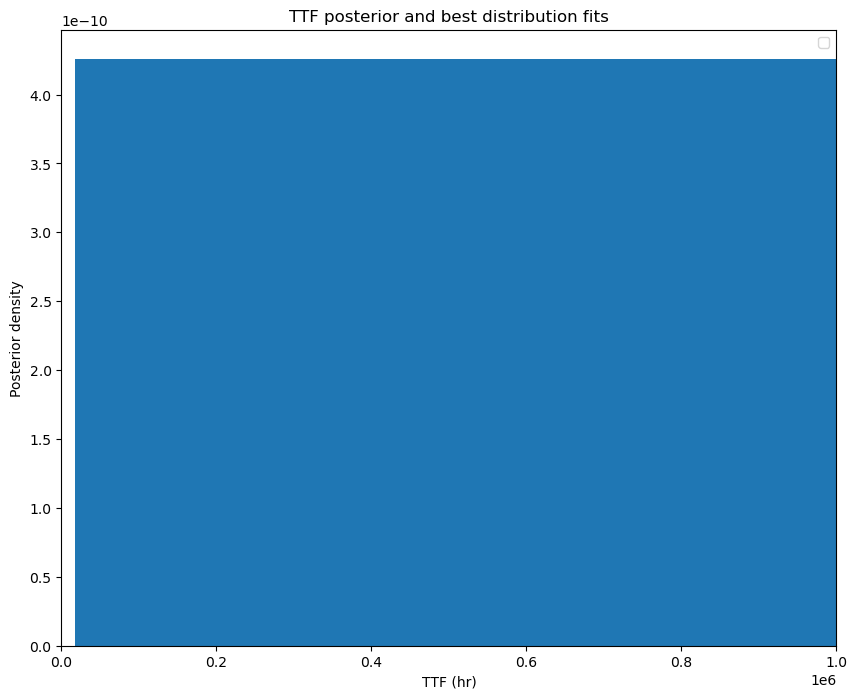

In [59]:
# 5) Posterior TTF PDF visualization
# --------------------------------

def _G_draw_factory_dual(g0, g1, Ea, n, sig, Df, T_eval_K, I_eval_mA):
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_eval_K))  # same accel convention as elsewhere
    def mu_of_t(t):
        base = t * accel * (I_eval_mA ** n)
        return (1.0 + g0 * (base ** g1)) ** (-1.0)
    def G_draw(t):
        mu = mu_of_t(t)
        # Failure when D(t) <= Df  -> use lower tail
        return norm.cdf((Df - mu) / sig)
    return G_draw, accel

def _suggest_t_hi_dual(g0, g1, Ea, n, Df, T_eval_K, I_eval_mA, mult=5.0):
    g0 = max(g0, 1e-30)
    g1 = max(g1, 1e-12)
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_eval_K))
    rhs = (1.0 / Df) - 1.0
    rhs = max(rhs, 1e-30)
    num = rhs / g0
    t_det = (num ** (1.0 / g1)) / (accel * (I_eval_mA ** n))
    t_det = float(np.clip(t_det, 1e-9, 1e12))
    return mult * t_det

def _grow_bracket(G_draw, u, t_hi0, t_hi_max=1e12):
    t_hi = max(1.0, float(t_hi0))
    val = float(G_draw(t_hi))
    it = 0
    while (val < u) and (t_hi < t_hi_max) and (it < 60):
        t_hi *= 2.0
        val = float(G_draw(t_hi))
        it += 1
    return t_hi if val >= u else np.nan

def draw_ttf_with_error_dual(g0_s, g1_s, Ea_s, n_s, sig_s, Df, T_eval_K, I_eval_mA,
                             n_samps=5000, seed=4):

    rng = np.random.default_rng(seed)
    n_draws = len(g0_s)
    idx = rng.integers(0, n_draws, size=n_samps)
    out = []
    for i in idx:
        g0, g1, Ea, n, sig = float(g0_s[i]), float(g1_s[i]), float(Ea_s[i]), float(n_s[i]), float(sig_s[i])
        # Build CDF of TTF at use
        G_draw, _ = _G_draw_factory_dual(g0, g1, Ea, n, sig, Df, T_eval_K, I_eval_mA)
        u = rng.random()
        # If already failed at t=0 (rare), record 0
        if G_draw(0.0) >= u:
            out.append(0.0)
            continue
        # Bracket using deterministic crossing
        t_hi0 = _suggest_t_hi_dual(g0, g1, Ea, n, Df, T_eval_K, I_eval_mA, mult=5.0)
        t_hi  = _grow_bracket(G_draw, u, t_hi0)
        if not np.isfinite(t_hi):
            t_hi = _grow_bracket(G_draw, u, 1.0)
            if not np.isfinite(t_hi):
                continue
        try:
            t = brentq(lambda t: G_draw(t) - u, 0.0, t_hi, maxiter=200)
            if np.isfinite(t) and t >= 0:
                out.append(float(t))
        except ValueError:
            continue
    return np.asarray(out)

# --- Sample TTF PDF ---

Df = 0.7
T_eval_K = T_use
I_eval_mA = I_use

ttf_err = draw_ttf_with_error_dual(g0_s, g1_s, Ea_s, n_s, sig_s, Df, T_eval_K, I_eval_mA, n_samps=8000, seed=24)

# --- Print results ---
def summarize_ttf(samples, hdi_prob=0.95, label="TTF (hr)", unit_label="hr"):
    s = np.asarray(samples)
    s = s[np.isfinite(s)]
    mean   = float(s.mean())
    median = float(np.median(s))
    lo, hi = az.hdi(s, hdi_prob=hdi_prob)  # Highest Density Interval
    # Equal-tailed interval too (optional)
    eti_lo, eti_hi = np.percentile(s, [(1-hdi_prob)/2*100, (1-(1-hdi_prob)/2)*100])
    print(f"\nPosterior summary for {label}:\033[0m")
    print("-" * 60)
    print(f"Mean life at use conditions: {mean:,.0f} {unit_label}")
    print(f"Median life:                 {median:,.0f} {unit_label}")
    print(f"{int(hdi_prob*100)}% HDI:                 [{lo:,.0f}, {hi:,.0f}] {unit_label}")
    print(f"{int(hdi_prob*100)}% ETI:                 [{eti_lo:,.0f}, {eti_hi:,.0f}] {unit_label}")
    print("-" * 60)
    return {"mean": mean, "median": median, "hdi": (float(lo), float(hi)), "eti": (float(eti_lo), float(eti_hi))}

summary = summarize_ttf(ttf_err, hdi_prob=0.95, label="TTF (hr)")

# Find best parameters for each Dist
# Best_fit = Fit_Everything(failures=ttf_err, show_histogram_plot=False, show_probability_plot=False, show_PP_plot=False, show_best_distribution_probability_plot=False)

# Generate x-values for plotting
x = np.linspace(0.01, np.max(ttf_err), 500)

# # Calculate the most common PDFs for visual comparrison 
# W_pdf = weibull_min.pdf(x, c=Best_fit.Weibull_2P_beta, scale=Best_fit.Weibull_2P_alpha)
# G_pdf = gamma.pdf(x, a=Best_fit.Gamma_2P_beta, scale=Best_fit.Gamma_2P_alpha, loc=0)
# L_pdf = lognorm.pdf(x, s=Best_fit.Lognormal_2P_sigma, scale=np.exp(Best_fit.Lognormal_2P_mu), loc=0)

# Plot the PDF
plt.figure(figsize=(10, 8))
plt.hist(ttf_err, bins=2000, density=True)
# plt.plot(x, L_pdf, c="black", label=fr'Lognormal PDF ($\sigma$={Best_fit.Lognormal_2P_sigma:.2f}, $\mu$={np.exp(Best_fit.Lognormal_2P_mu):.0f})')
# plt.plot(x, G_pdf, c="orange", label=fr'Gamma PDF ($\beta$={Best_fit.Gamma_2P_beta:.2f}, $\alpha$={Best_fit.Gamma_2P_alpha:.0f})')
# plt.plot(x, W_pdf, c="blue", label=fr'Weibull PDF ($\beta$={Best_fit.Weibull_2P_beta:.2f}, $\alpha$={Best_fit.Weibull_2P_alpha:.0f})')
plt.xlabel("TTF (hr)")
plt.ylabel("Posterior density")
plt.title("TTF posterior and best distribution fits")
plt.xlim(0,1e6)
plt.legend()
plt.show()